In [9]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

from tcrdist.rep_funcs import _pws, _pw
from tcrdist.repertoire import TCRrep

from raptcr.constants.preprocessing import add_cdr_columns, to_tcrdist3_format
from raptcr.hashing import Cdr3Hasher

In [3]:
df = pd.read_csv('./data/example_repertoire.tsv', sep='\t')
df = add_cdr_columns(df)
df = to_tcrdist3_format(df)

sub = df[:5000]
sub

,v_b_gene,j_b_gene,cdr3_b_aa,cdr1_b_aa,cdr2_b_aa
0,TRBV5-5*01,TRBJ1-1*01,CASSSGQGVESTEAFF,SGHKS,YYEKEE
1,TRBV5-5*01,TRBJ2-4*01,CASSLYTGIAKNIQYF,SGHKS,YYEKEE
2,TRBV5-5*01,TRBJ1-3*01,CASSLSGAGNTIYF,SGHKS,YYEKEE
3,TRBV5-5*01,TRBJ2-1*01,CASSLLAGPYNEQFF,SGHKS,YYEKEE
4,TRBV5-5*01,TRBJ2-1*01,CASSLGLTGRYNEQFF,SGHKS,YYEKEE
...,...,...,...,...,...
4995,TRBV2*01,TRBJ1-1*01,CASTADLGTEAFF,SNHLY,FYNNEI
4996,TRBV2*01,TRBJ1-5*01,CASSASSWLGERQPQHF,SNHLY,FYNNEI
4997,TRBV2*01,TRBJ1-1*01,CASSEAEGTMNTEAFF,SNHLY,FYNNEI
4998,TRBV30*01,TRBJ2-3*01,CAWSVGGVGTQYF,GTSNPN,SVGIG


In [4]:
import pwseqdist as pw

# Choose the metrics you want to apply to each CDR
metrics = { 'cdr3_b_aa' : pw.metrics.nb_vector_tcrdist,
            'cdr2_b_aa' : pw.metrics.nb_vector_tcrdist,
            'cdr1_b_aa' : pw.metrics.nb_vector_tcrdist}

# Choose the weights that are right for you.
weights = { 'cdr3_b_aa' : 3,
            'cdr2_b_aa' : 1,
            'cdr1_b_aa' : 1}

# Provide arguments for the distance metrics 
kargs = {   'cdr3_b_aa' : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':3, 'ntrim':0, 'ctrim':0, 'fixed_gappos':False},
            'cdr2_b_aa' : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':3, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True},
            'cdr1_b_aa' : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':3, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True}}
            
# Here are your distance matrices
from tcrdist.rep_funcs import _pws

dmats = _pws(df = sub,
         metrics = metrics, 
         weights= weights, 
         kargs=kargs,
         cpu = 1, 
         store = True)

m = dmats['tcrdist']

In [5]:
cdrs = [f'cdr{i}_b_aa' for i in range(1,4)]
sub['full'] = sub[cdrs[0]] + sub[cdrs[1]] + sub[cdrs[2]]

cdr1hasher = Cdr3Hasher(m=10).fit()
cdr2hasher = Cdr3Hasher(m=10).fit()
cdr3hasher = Cdr3Hasher(m=64).fit()
fullhasher = Cdr3Hasher(m=128).fit()

# 20-D BLOSUM, no MDS 
alt_hasher = Cdr3Hasher(m=20, scale=False).fit()

sub['cdr1_embedding'] = list(cdr1hasher.fit_transform(sub.cdr1_b_aa.tolist()))
sub['cdr2_embedding'] = list(cdr2hasher.fit_transform(sub.cdr2_b_aa.tolist()))
sub['cdr3_embedding'] = list(cdr3hasher.fit_transform(sub.cdr3_b_aa.tolist()))
sub['full_embedding'] = list(fullhasher.fit_transform(sub.full.tolist()))
sub['full_nomds'] = list(alt_hasher.fit_transform(sub.full.tolist()))
sub['cdr3_nomds'] = list(alt_hasher.fit_transform(sub.cdr3_b_aa.tolist()))

embeddings = ['cdr1_embedding', 'cdr2_embedding', 'cdr3_embedding']
sub['tcr_embedding'] = sub[embeddings].apply(lambda x:  np.concatenate((x[0], x[1], x[2])), axis=1)


alt_embeddings = ['cdr1_embedding', 'cdr2_embedding', 'cdr3_nomds']
sub['tcr_embedding_alt'] = sub[alt_embeddings].apply(lambda x:  np.concatenate((x[0], x[1], x[2])), axis=1)

/tmp/ipykernel_399572/1898713842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['full'] = sub[cdrs[0]] + sub[cdrs[1]] + sub[cdrs[2]]
/tmp/ipykernel_399572/1898713842.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['cdr1_embedding'] = list(cdr1hasher.fit_transform(sub.cdr1_b_aa.tolist()))
/tmp/ipykernel_399572/1898713842.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [6]:
from raptcr.constants.distributions import gaussian_vector

wvec_full = gaussian_vector(nbins=128)
sub['full_embedding_weighted'] = sub['full_embedding'].apply(lambda x: x * wvec_full)

wvec_tcr = gaussian_vector(nbins=64)
wvec_tcr = np.concatenate([np.ones(64), wvec_tcr])
sub['tcr_embedding_weighted'] = sub['tcr_embedding'].apply(lambda x: x * wvec_tcr)

/tmp/ipykernel_372398/1613008332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['full_embedding_weighted'] = sub['full_embedding'].apply(lambda x: x * wvec_full)
/tmp/ipykernel_372398/1613008332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['tcr_embedding_weighted'] = sub['tcr_embedding'].apply(lambda x: x * wvec_tcr)


In [12]:
sub.head(1)

,v_b_gene,j_b_gene,cdr3_b_aa,cdr1_b_aa,cdr2_b_aa,full,cdr1_embedding,cdr2_embedding,cdr3_embedding,full_embedding,full_nomds,cdr3_nomds,tcr_embedding
0,TRBV5-5*01,TRBJ1-1*01,CASSSGQGVESTEAFF,SGHKS,YYEKEE,SGHKSYYEKEECASSSGQGVESTEAFF,"[0.16483526, 0.16343689, -0.268962, -0.1551401...","[0.1396969, 0.11505631, -0.054190133, -0.00532...","[0.019697914, -0.012712883, 0.012179822, -0.06...","[0.05608896, 0.1675923, 0.0075974637, -0.00625...","[0.74627614, 0.043772835, 0.060025472, 0.10077...","[-0.0872018, 0.09294409, 0.050520524, 0.005218...","[0.16483526, 0.16343689, -0.268962, -0.1551401..."


Text(0.5, 0, 'Position in embedding')

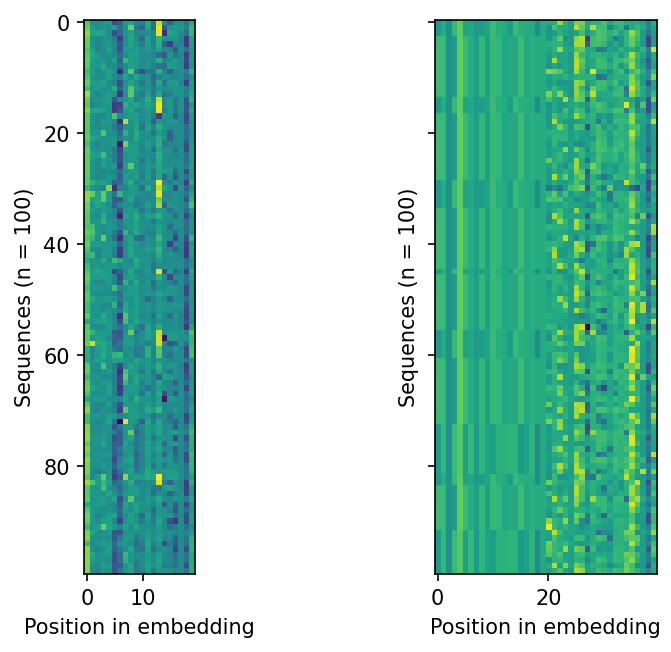

In [6]:
fig, ax = plt.subplots(dpi=150, nrows=1, ncols=2, sharey=True)

ax[0].imshow(np.stack(sub.full_nomds.to_list(), axis=0)[200:300])
# ax[0,0].set_title('Scenario 1')
ax[0].set_ylabel('Sequences (n = 100)')
ax[0].set_xlabel('Position in embedding')

ax[1].imshow(np.stack(sub.tcr_embedding_alt.to_list(), axis=0)[200:300])
# ax[0,0].set_title('Scenario 1')
ax[1].set_ylabel('Sequences (n = 100)')
ax[1].set_xlabel('Position in embedding')


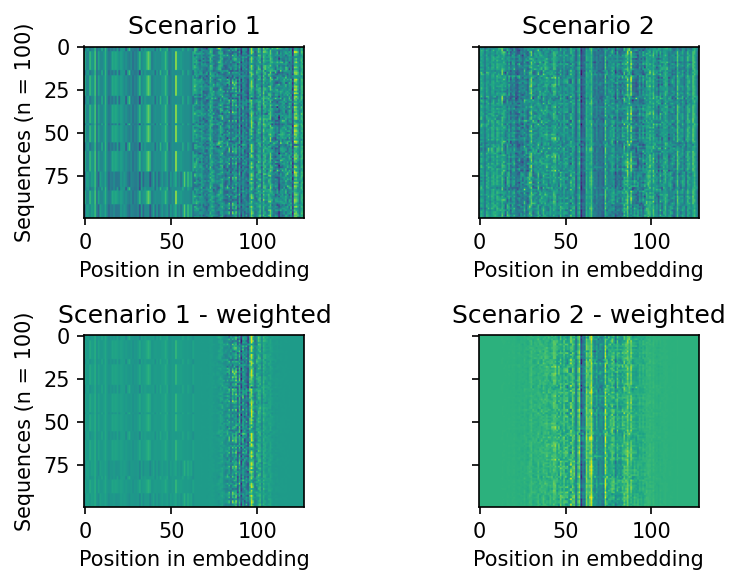

In [7]:
fig, ax = plt.subplots(dpi=150, nrows=1, ncols=2, sharey=True)

ax[0].imshow(np.stack(sub.tcr_embedding.to_list(), axis=0)[200:300])
# ax[0].set_title('Scenario 1')
ax[0].set_ylabel('Sequences (n = 100)')
ax[0].set_xlabel('Position in embedding')

# ax[0,0].imshow(np.stack(sub.tcr_embedding.to_list(), axis=0)[200:300])
# ax[0,0].set_title('Scenario 1')
# ax[0,0].set_ylabel('Sequences (n = 100)')
# ax[0,0].set_xlabel('Position in embedding')

# ax[0,1].imshow(np.stack(sub.full_embedding.to_list(), axis=0)[200:300])
# ax[0,1].set_title('Scenario 2')
# ax[0,1].set_xlabel('Position in embedding')

# ax[1,0].imshow(np.stack(sub.tcr_embedding_weighted.to_list(), axis=0)[200:300])
# ax[1,0].set_title('Scenario 1 - weighted')
# ax[1,0].set_ylabel('Sequences (n = 100)')
# ax[1,0].set_xlabel('Position in embedding')

# ax[1,1].imshow(np.stack(sub.full_embedding_weighted.to_list(), axis=0)[200:300])
# ax[1,1].set_title('Scenario 2 - weighted')
# ax[1,1].set_xlabel('Position in embedding')

fig.tight_layout()

In [17]:
from scipy.spatial.distance import squareform

def weightedL2(a,b,w):
    q = a-b
    return np.sqrt((w*q*q).sum())

# No weights
l2full = pdist(X=sub.full_embedding.to_list(), metric='euclidean')
l2tcr = pdist(X=sub.tcr_embedding.to_list(), metric='euclidean')

# Weights added 
l2fullw = pdist(X=sub.full_embedding_weighted.to_list(), metric='euclidean')
l2tcrw = pdist(X=sub.tcr_embedding_weighted.to_list(), metric='euclidean')

# Weighted L2 
l2wfull = pdist(X=sub.full_embedding_weighted.to_list(), metric=weightedL2, w=wvec_full)
l2wtcr = pdist(X=sub.tcr_embedding_weighted.to_list(), metric=weightedL2, w=wvec_tcr)

# l2cdr3 = pdist(X=sub.cdr3_embedding.to_list(), metric='euclidean')
# l2cdr2 = pdist(X=sub.cdr2_embedding.to_list(), metric='euclidean')
# l2cdr1 = pdist(X=sub.cdr1_embedding.to_list(), metric='euclidean')

# res = pd.DataFrame({'l2full':l2full, 'l2tcr':l2tcr, 'l2cdr3':l2cdr3, 'l2cdr2':l2cdr2, 'l2cdr1':l2cdr1, 'tcrdist':squareform(m)})
res = pd.DataFrame({'l2full':l2full, 'l2tcr':l2tcr, 'l2fullw':l2fullw, 'l2tcrw':l2tcrw, 'l2wfull':l2wfull, 'l2wtcr':l2wtcr, 'tcrdist':squareform(m)})
res.head()


,l2full,l2tcr,l2fullw,l2tcrw,l2wfull,l2wtcr,tcrdist
0,0.970798,0.867433,2.125617,1.640930,3.786431,2.742714,99
1,0.840142,0.727009,1.693714,1.256554,2.916131,2.130100,114
2,0.920946,1.026505,1.869786,1.895913,3.247451,3.206970,93
3,0.877784,0.919736,1.603692,1.709269,2.745266,2.921080,96
4,0.988194,0.903344,1.856762,1.609733,3.203480,2.795541,84


In [7]:
# No weights
l2full = pdist(X=sub.full_nomds.to_list(), metric='euclidean')
l2tcr = pdist(X=sub.tcr_embedding_alt.to_list(), metric='euclidean')

res = pd.DataFrame({'test_1':l2full, 'test_2':l2tcr, 'tcrdist':squareform(m)})
res.head()


,test_1,test_2,tcrdist
0,1.490337,0.996786,99
1,1.165177,1.171032,114
2,1.684125,1.205470,93
3,1.506013,1.163031,96
4,1.404082,1.584536,84


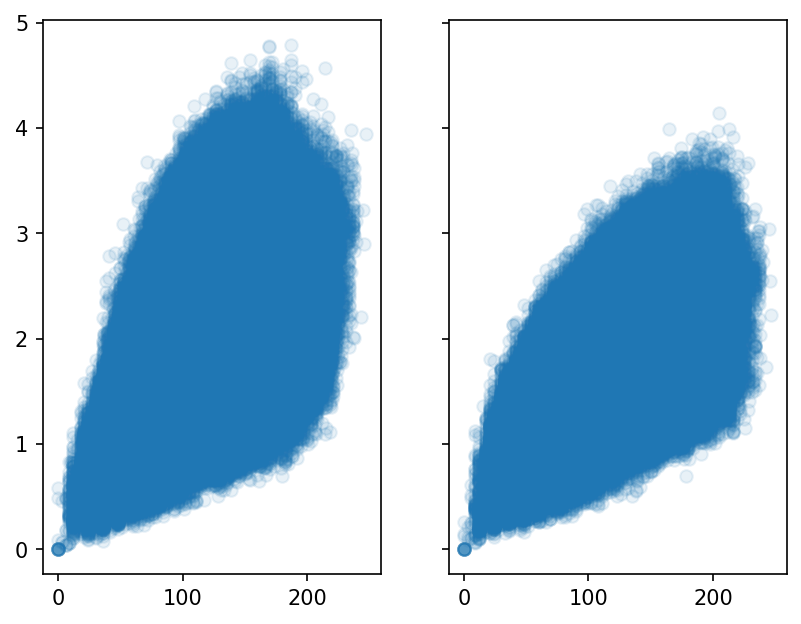

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150, sharey=True)

ax[0].scatter(
    x = 'tcrdist',
    y = 'test_1',
    data = res[:1000000],
    alpha = .1
)
ax[1].scatter(
    x = 'tcrdist',
    y = 'test_2',
    data = res[:1000000],
    alpha = .1
)

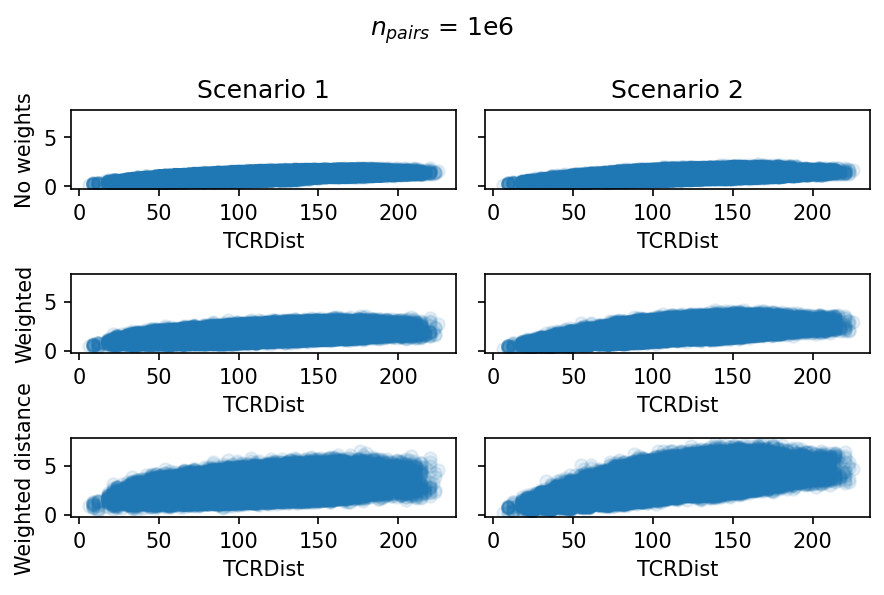

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2, dpi=150, sharey=True)

# ROW 1

ax[0,0].scatter(
    y = 'l2tcr',
    x = 'tcrdist',
    data = res[:1000000],
    alpha = .1
)

ax[0,0].set_ylabel('No weights')
ax[0,0].set_xlabel('TCRDist')

ax[0,1].scatter(
    y = 'l2full',
    x = 'tcrdist',
    data = res[:1000000],
    alpha = .1
)

# ax[0,1].set_ylabel('Scenario 2 - no weights')
ax[0,1].set_xlabel('TCRDist'),

# ROW 2

ax[1,0].scatter(
    y = 'l2tcrw',
    x = 'tcrdist',
    data = res[:1000000],
    alpha = .1
)

ax[1,0].set_ylabel('Weighted')
ax[1,0].set_xlabel('TCRDist')

ax[1,1].scatter(
    y = 'l2fullw',
    x = 'tcrdist',
    data = res[:1000000],
    alpha = .1
)

# ax[1,1].set_ylabel('Scenario 2 - weighted')
ax[1,1].set_xlabel('TCRDist')

# ROW 3

ax[2,0].scatter(
    y = 'l2wtcr',
    x = 'tcrdist',
    data = res[:1000000],
    alpha = .1
)

ax[2,0].set_ylabel('Weighted distance')
ax[2,0].set_xlabel('TCRDist')

ax[2,1].scatter(
    y = 'l2wfull',
    x = 'tcrdist',
    data = res[:1000000],
    alpha = .1
)

# ax[1,1].set_ylabel('Scenario 2 - weighted')
ax[2,1].set_xlabel('TCRDist')

ax[0,0].set_title('Scenario 1')
ax[0,1].set_title('Scenario 2')

fig.suptitle(r'$n_{pairs}$ = 1e6')
fig.tight_layout()

In [124]:
example = np.stack(df.tcr_embedding.to_list(), axis=0)[:10]

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, ''),
 Text(140.0, 0, '')]

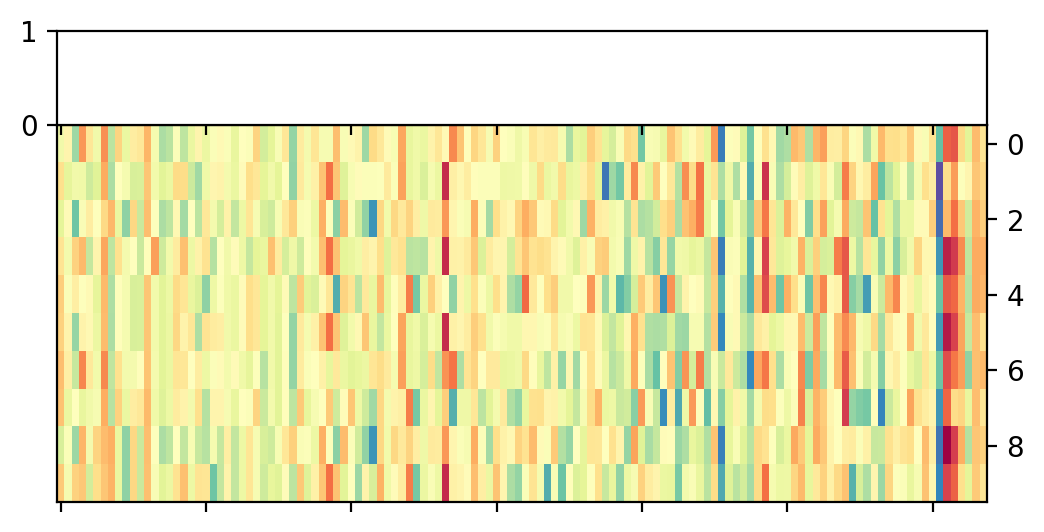

In [131]:
# # Clustering params
# self.method = method
# self.metric = metric
# self.cd = col_dendrogram
# self.rd = row_dendrogram

import matplotlib as mpl

# Figure setup
fig = plt.figure(
    # figsize = (3,5), 
    dpi = 200
    )

gs0 = mpl.gridspec.GridSpec(
    nrows = 2,
    ncols = 1, 
    figure = fig,
    height_ratios = [8,2],
    hspace = 0.05
    )

gs1 = mpl.gridspec.GridSpecFromSubplotSpec(
    nrows = 2, 
    ncols = 1, 
    subplot_spec = gs0[0],
    height_ratios = [2,8],
    hspace=0
    )

ax_heatmap = fig.add_subplot(gs1[1])

ax_col_dendrogram = fig.add_subplot(
    gs1[0], 
    sharex = ax_heatmap
    )

ax_heatmap.imshow(
            X = example, 
            aspect = 'auto', 
            # extent = [xmin,self.xmax,0,1], 
            cmap = 'Spectral_r'
            )
ax_heatmap.yaxis.tick_right()
# plt.setp(ax_heatmap.get_xticklabels(), visible=False)
ax_col_dendrogram.set_xticklabels('')

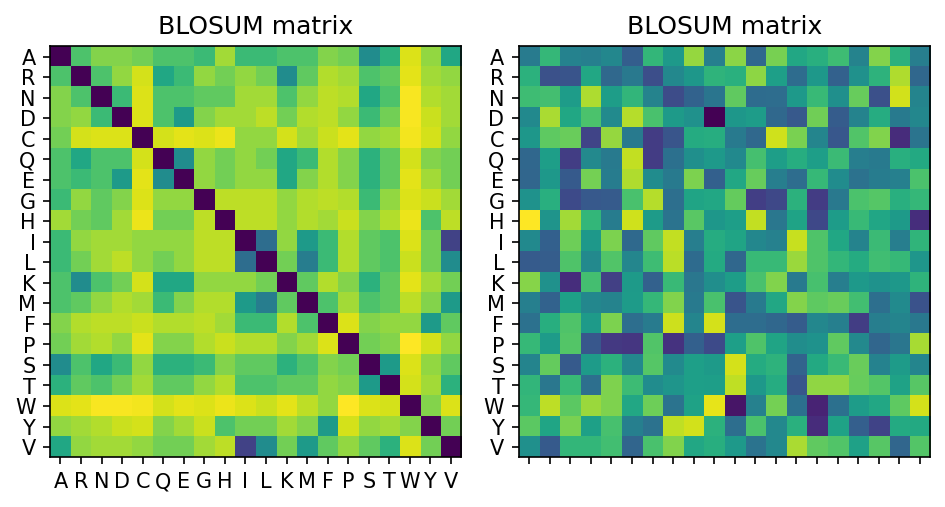

In [13]:
from raptcr.constants.hashing import DEFAULT_DM as blosum
from raptcr.constants.base import AALPHABET

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150)

ax[0].imshow(blosum)
ax[0].set_title('BLOSUM matrix')

ax[0].set_xticks(range(20))
ax[0].set_yticks(range(20))
ax[0].set_xticklabels(labels=AALPHABET)
ax[0].set_yticklabels(labels=AALPHABET)

from sklearn.manifold import MDS

blosum_scaled = MDS(n_components=20, dissimilarity="precomputed", random_state=11, normalized_stress=False).fit_transform(blosum)

ax[1].imshow(blosum_scaled)
ax[1].set_title('BLOSUM matrix')

ax[1].set_xticks(range(20))
ax[1].set_yticks(range(20))
ax[1].set_xticklabels(labels='')
ax[1].set_yticklabels(labels=AALPHABET)

fig.tight_layout()

In [7]:
hasher_a = Cdr3Hasher(m=20, scale=False).fit()
hasher_b = Cdr3Hasher(m=10, scale=True).fit()

[Text(0, 0, 'C'),
 Text(0, 1, 'A'),
 Text(0, 2, 'S'),
 Text(0, 3, 'S'),
 Text(0, 4, 'S'),
 Text(0, 5, 'G'),
 Text(0, 6, 'Q'),
 Text(0, 7, 'G'),
 Text(0, 8, 'V'),
 Text(0, 9, 'E'),
 Text(0, 10, 'S'),
 Text(0, 11, 'T'),
 Text(0, 12, 'E'),
 Text(0, 13, 'A'),
 Text(0, 14, 'F'),
 Text(0, 15, 'F')]

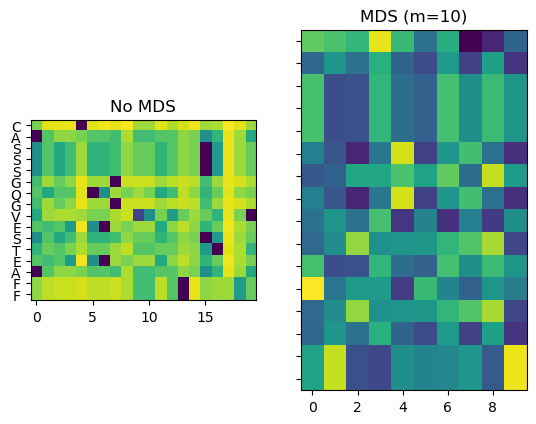

In [8]:
test = 'CASSSGQGVESTEAFF'

fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].imshow(np.vstack([hasher_a.aa_vectors_[i] for i in test]))
ax[0].set_title('No MDS')
ax[1].imshow(np.vstack([hasher_b.aa_vectors_[i] for i in test]))
ax[1].set_title('MDS (m=10)')

ax[0].set_yticks(range(len(test)))
ax[0].set_yticklabels(list(test))